In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from system_ode_fedbatch import generate_data
from machinelearning_control_fedbatch import main, generate_dataset

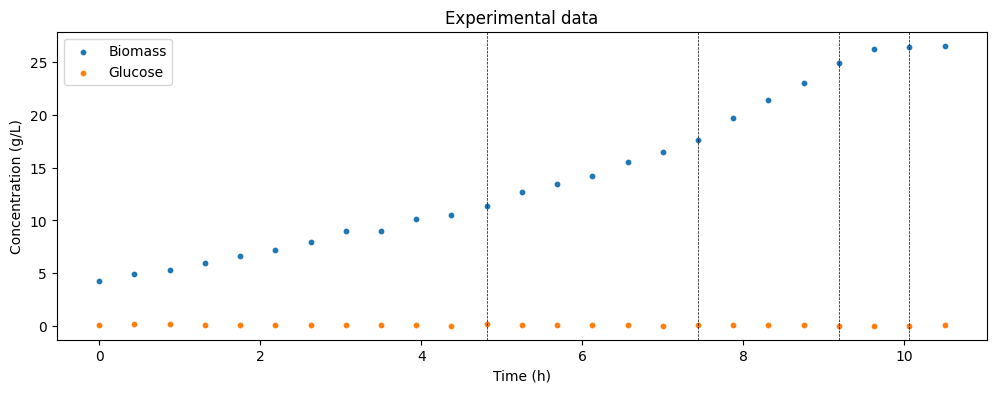

In [3]:
full_df = generate_data()

plt.figure(figsize=(12, 4))
plt.scatter(full_df['RTime'], full_df['Biomass'], s=10, label='Biomass')
plt.scatter(full_df['RTime'], full_df['Glucose'], s=10, label='Glucose')
for i in range(1, len(full_df)):
    if full_df["F"].iloc[i] != full_df["F"].iloc[i - 1]:
        plt.axvline(x=full_df["RTime"].iloc[i], color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.title('Experimental data')
plt.show()

In [4]:
# Get features and targets
in_train, out_train = generate_dataset(full_df)

Dataset shape: (100, 4)


In [5]:
# Trying to generate the collocation points
in_train[0]


tensor([0.0000, 3.6050, 0.0757, 0.0624], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [6]:
stop

NameError: name 'stop' is not defined

In [ ]:
# parameter values
mumax = 0.84     # 1/hour
Ks = 0.2          # g/liter
Yxs = 0.5         # g/g
Sin = 1.43 * 200  # g/liter

# initial conditions
t_start = full_df['RTime'].iloc[0]
t_end = full_df['RTime'].iloc[-1]
V0 = full_df['V'].iloc[0]
S0 = full_df['Glucose'].iloc[0]

print(f'T_start = {t_start}')
print(f'T_end = {t_end}')

In [ ]:
net = main(in_train, out_train, t_start, t_end, Sin, S0, mumax, Ks, Yxs, verbose=10)

In [80]:
# pickle save the model
import pickle
with open("pinc_model.pkl", "wb") as f:
    pickle.dump(net, f)

# Autoregression

In [81]:
from machinelearning_control_fedbatch import numpy_to_tensor
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T_s = full_df['RTime'].iloc[1]
t_test = numpy_to_tensor(np.array([full_df["RTime"].values]))
X_test = numpy_to_tensor(np.array([full_df["Biomass"].values]))
S_test = numpy_to_tensor(np.array([full_df["Glucose"].values]))
F_test = numpy_to_tensor(np.array([full_df["F"].values]))
u_test = torch.cat([t_test, X_test, S_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test], dim=1)

In [82]:
X_0 = X_test[0]
S_0 = S_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
for i in range(len(u_test)):
    x_k = net.forward(torch.tensor([T_s, X_0, S_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())

In [83]:
t_test = t_test.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()
S_test = S_test.detach().cpu().numpy()

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(t_test, X_test, s=10, label="X")
plt.scatter(t_test, S_test, s=10, label="S")

plt.plot(t_test, X_preds, marker='x', label="X_pred")
plt.plot(t_test, S_preds, marker='x', label="S_pred")

plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()